In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import itertools

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=32)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")
df_BOT= creator.reader("NF-BoT-IoT-v3")
df_CIC= creator.reader("NF-CICIDS2018-v3")

In [4]:
df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [5]:
df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [6]:
df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [7]:
loader_names = ['UNSW', 'BOT', 'CIC', 'BOTH']
test_ids = [1, 2, 3]
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [10]:
def train_model(model, train_loaders, val_loaders, epochs, weight1, weight2, lr, device, patience=15):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    max_train_batches = max(len(l) for l in train_loaders) 
    train_iter_loaders = [itertools.cycle(l) if len(l) < max_train_batches else l for l in train_loaders]
    
    max_val_batches = max(len(l) for l in val_loaders)
    val_iter_loaders = [itertools.cycle(l) if len(l) < max_val_batches else l for l in val_loaders]

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        loader_iterators = [iter(l) for l in train_iter_loaders]
        
        for _ in range(max_train_batches):
            try:
                batches = [next(it) for it in loader_iterators]
            except StopIteration:
                break
            
            (inputs_a, labels_a) = batches[0]
            (inputs_b, labels_b) = batches[1]
            (inputs_c, labels_c) = batches[2]
            
            inputs = torch.cat((inputs_a, inputs_b, inputs_c), dim=0)
            labels = torch.cat((labels_a, labels_b, labels_c), dim=0)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs1 = model.forward_exit1(inputs)
            loss1 = criterion(outputs1, labels)
            
            outputs2 = model.forward_exit2(inputs)
            loss2 = criterion(outputs2, labels)
                
            total_loss = (weight1 * loss1) + (weight2 * loss2)

            total_loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += total_loss.item()
        
        epoch_train_loss = running_train_loss / max_train_batches
        train_loss_history.append(epoch_train_loss)

        val_loss = 0
        model.eval()
        
        val_loader_iterators = [iter(l) for l in val_iter_loaders]

        with torch.no_grad():
            for _ in range(max_val_batches):
                try:
                    batches = [next(it) for it in val_loader_iterators]
                except StopIteration:
                    break

                (inputs_a, labels_a) = batches[0]
                (inputs_b, labels_b) = batches[1]
                (inputs_c, labels_c) = batches[2]
                
                inputs = torch.cat((inputs_a, inputs_b, inputs_c), dim=0)
                labels = torch.cat((labels_a, labels_b, labels_c), dim=0)
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs1 = model.forward_exit1(inputs)
                loss1 = criterion(outputs1, labels)
                
                outputs2 = model.forward_exit2(inputs)
                loss2 = criterion(outputs2, labels)
                    
                total_loss = (weight1 * loss1) + (weight2 * loss2)
                
                val_loss += total_loss.item()
        
        epoch_val_loss = val_loss / max_val_batches
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\n--- EARLY STOPPING ATIVADO ---')
            print(f'Parando o treino na época {epoch+1}. Melhor loss: {best_val_loss:.4f}')
            if best_model_state:
                model.load_state_dict(best_model_state)
            break
            
        scheduler.step(epoch_val_loss) 

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Loss de Treinamento')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curvas de Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_loss_history, val_loss_history

In [11]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    start_time = time.perf_counter()

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            branch_conf, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = branch_conf > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    end_time = time.perf_counter()
    
    total_inference_time = end_time - start_time

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = correct / total_samples
    exit_rate = exited_early_count / total_samples
    
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples,
            'total_inference_time_sec': total_inference_time
        }

In [12]:
modelname = 'BOTH_EA'

--- Training model: BOTH_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6582, Validation Loss: 0.5935
Epoch [2/500], Train Loss: 0.5464, Validation Loss: 0.4957
Epoch [3/500], Train Loss: 0.4952, Validation Loss: 0.4624
Epoch [4/500], Train Loss: 0.4686, Validation Loss: 0.4411
Epoch [5/500], Train Loss: 0.4519, Validation Loss: 0.4253
Epoch [6/500], Train Loss: 0.4351, Validation Loss: 0.4112
Epoch [7/500], Train Loss: 0.4224, Validation Loss: 0.3986
Epoch [8/500], Train Loss: 0.4073, Validation Loss: 0.3860
Epoch [9/500], Train Loss: 0.3964, Validation Loss: 0.3744
Epoch [10/500], Train Loss: 0.3844, Validation Loss: 0.3646
Epoch [11/500], Train Loss: 0.3737, Validation Loss: 0.3531
Epoch [12/500], Train Loss: 0.3636, Validation Loss: 0.3462
Epoch [13/500], Train Loss: 0.3558, Validation Loss: 0.3367
Epoch [14/500], Train Loss: 0.3488, Validation Loss: 0.3311
Epoch [15/500], Train Loss: 0.3439, Validation Loss: 0.3243
Epoch [16/500], Train Loss: 0.3359, Validati

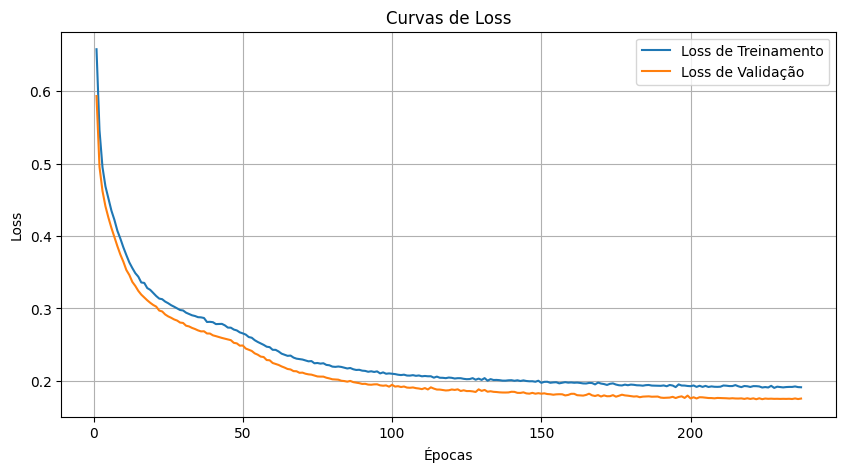

Model saved at 'models/BOTH_EA_1.pth'

--- Training model: BOTH_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.5839, Validation Loss: 0.4919
Epoch [2/500], Train Loss: 0.5011, Validation Loss: 0.4450
Epoch [3/500], Train Loss: 0.4642, Validation Loss: 0.4214
Epoch [4/500], Train Loss: 0.4393, Validation Loss: 0.3993
Epoch [5/500], Train Loss: 0.4183, Validation Loss: 0.3803
Epoch [6/500], Train Loss: 0.3998, Validation Loss: 0.3515
Epoch [7/500], Train Loss: 0.3855, Validation Loss: 0.3382
Epoch [8/500], Train Loss: 0.3687, Validation Loss: 0.3435
Epoch [9/500], Train Loss: 0.3595, Validation Loss: 0.3129
Epoch [10/500], Train Loss: 0.3462, Validation Loss: 0.3100
Epoch [11/500], Train Loss: 0.3369, Validation Loss: 0.2892
Epoch [12/500], Train Loss: 0.3262, Validation Loss: 0.2835
Epoch [13/500], Train Loss: 0.3174, Validation Loss: 0.2740
Epoch [14/500], Train Loss: 0.3088, Validation Loss: 0.2819
Epoch [15/500], Train Loss: 0.3016, Validation Loss: 0.2643
Epoch

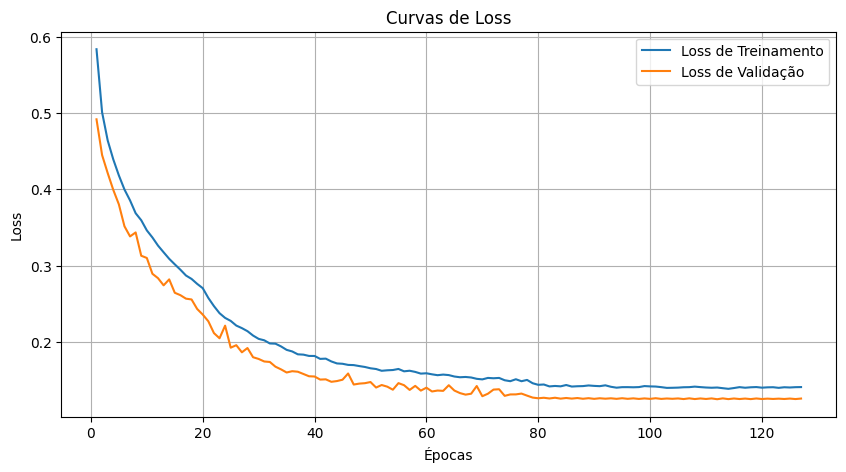

Model saved at 'models/BOTH_EA_2.pth'

--- Training model: BOTH_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.2493, Validation Loss: 1.1236
Epoch [2/500], Train Loss: 1.0960, Validation Loss: 1.0082
Epoch [3/500], Train Loss: 1.0009, Validation Loss: 0.9303
Epoch [4/500], Train Loss: 0.9311, Validation Loss: 0.8630
Epoch [5/500], Train Loss: 0.8862, Validation Loss: 0.8409
Epoch [6/500], Train Loss: 0.8478, Validation Loss: 0.8012
Epoch [7/500], Train Loss: 0.8203, Validation Loss: 0.7639
Epoch [8/500], Train Loss: 0.7907, Validation Loss: 0.7391
Epoch [9/500], Train Loss: 0.7666, Validation Loss: 0.7294
Epoch [10/500], Train Loss: 0.7443, Validation Loss: 0.6820
Epoch [11/500], Train Loss: 0.7219, Validation Loss: 0.6718
Epoch [12/500], Train Loss: 0.7047, Validation Loss: 0.6733
Epoch [13/500], Train Loss: 0.6876, Validation Loss: 0.6369
Epoch [14/500], Train Loss: 0.6749, Validation Loss: 0.6280
Epoch [15/500], Train Loss: 0.6564, Validation Loss: 0.6168
Epoch

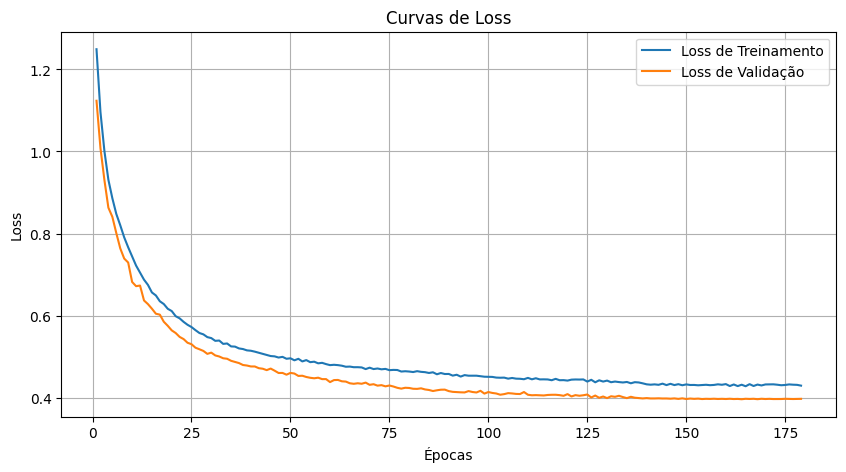

Model saved at 'models/BOTH_EA_3.pth'



In [18]:
epochs = 500

for test in test_ids:
    model = IDSBranchyNet()
    
    if test == 1:
        weight1 = 1
        weight2 = 0
    elif test == 2:
        weight1 = 0
        weight2 = 1
    elif test == 3:
        weight1 = 1
        weight2 = 1
        
    
        
    print(f"--- Training model: {modelname} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
    
    train_losses, val_losses = train_model(model, train_loaders, val_loaders, epochs, weight1, weight2, lr=0.0001, device=device)

    torch.save(model.state_dict(), f'models/{modelname}_{test}.pth')
    print(f"Model saved at 'models/{modelname}_{test}.pth'\n")
    

--- Model: BOTH_EA | Loader: UNSW | TestID: 1 | Threshold: 0 ---
Model from: 'models/BOTH_EA_1.pth' carregado


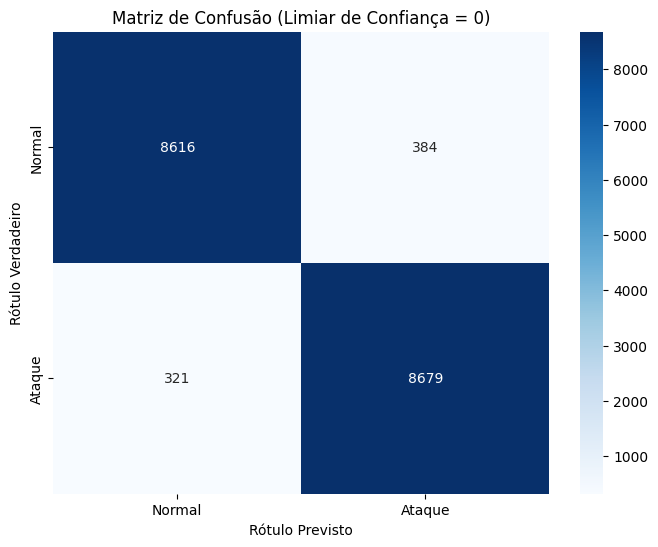

True Positives (TP): 8679
True Negatives (TN): 8616
False Positives (FP): 384
False Negatives (FN): 321

F1 Score: 0.9610
True Positive Rate (TPR) / Recall: 0.9643
True Negative Rate (TNR) / Specificity: 0.9573
--------------------
Threshold: 0
  Accuracy: 0.9608%
  Total Inference Time: 0.6515 s
  Early Exit Rate: 1.0000% (18000/18000)
--------------------


--- Model: BOTH_EA | Loader: UNSW | TestID: 2 | Threshold: 2 ---
Model from: 'models/BOTH_EA_2.pth' carregado


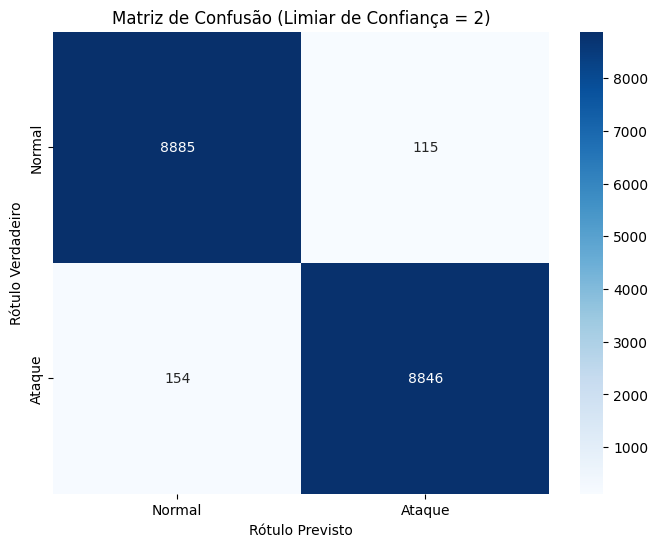

True Positives (TP): 8846
True Negatives (TN): 8885
False Positives (FP): 115
False Negatives (FN): 154

F1 Score: 0.9850
True Positive Rate (TPR) / Recall: 0.9829
True Negative Rate (TNR) / Specificity: 0.9872
--------------------
Threshold: 2
  Accuracy: 0.9851%
  Total Inference Time: 0.9429 s
  Early Exit Rate: 0.0000% (0/18000)
--------------------


--- Model: BOTH_EA | Loader: UNSW | TestID: 3 | Threshold: 0.99 ---
Model from: 'models/BOTH_EA_3.pth' carregado


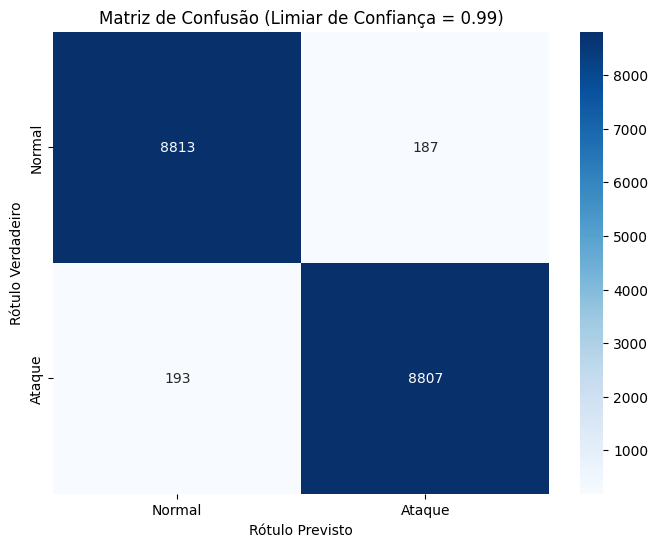

True Positives (TP): 8807
True Negatives (TN): 8813
False Positives (FP): 187
False Negatives (FN): 193

F1 Score: 0.9789
True Positive Rate (TPR) / Recall: 0.9786
True Negative Rate (TNR) / Specificity: 0.9792
--------------------
Threshold: 0.99
  Accuracy: 0.9789%
  Total Inference Time: 1.0433 s
  Early Exit Rate: 0.1880% (3384/18000)
--------------------


--- Model: BOTH_EA | Loader: BOT | TestID: 1 | Threshold: 0 ---
Model from: 'models/BOTH_EA_1.pth' carregado


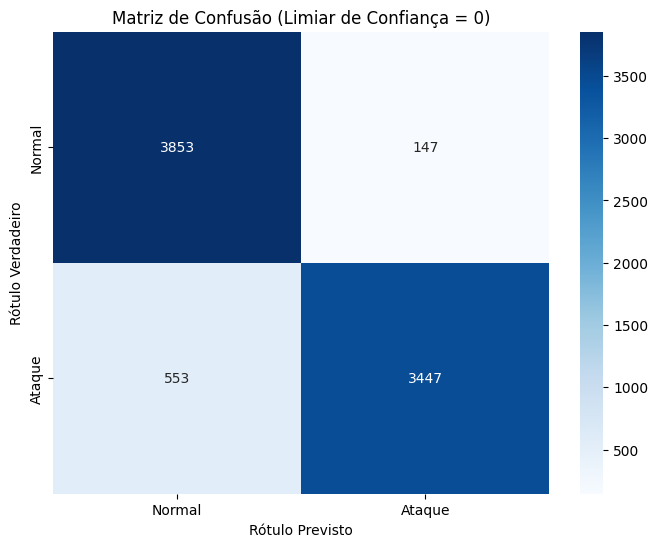

True Positives (TP): 3447
True Negatives (TN): 3853
False Positives (FP): 147
False Negatives (FN): 553

F1 Score: 0.9078
True Positive Rate (TPR) / Recall: 0.8618
True Negative Rate (TNR) / Specificity: 0.9633
--------------------
Threshold: 0
  Accuracy: 0.9125%
  Total Inference Time: 0.2931 s
  Early Exit Rate: 1.0000% (8000/8000)
--------------------


--- Model: BOTH_EA | Loader: BOT | TestID: 2 | Threshold: 2 ---
Model from: 'models/BOTH_EA_2.pth' carregado


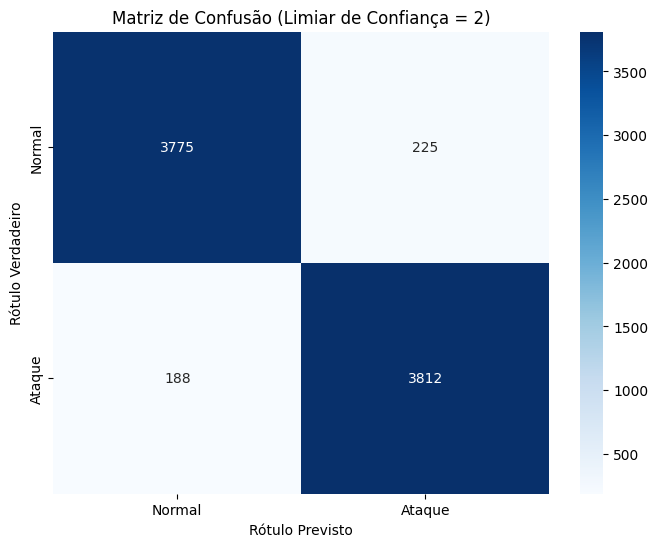

True Positives (TP): 3812
True Negatives (TN): 3775
False Positives (FP): 225
False Negatives (FN): 188

F1 Score: 0.9486
True Positive Rate (TPR) / Recall: 0.9530
True Negative Rate (TNR) / Specificity: 0.9437
--------------------
Threshold: 2
  Accuracy: 0.9484%
  Total Inference Time: 0.4562 s
  Early Exit Rate: 0.0000% (0/8000)
--------------------


--- Model: BOTH_EA | Loader: BOT | TestID: 3 | Threshold: 0.99 ---
Model from: 'models/BOTH_EA_3.pth' carregado


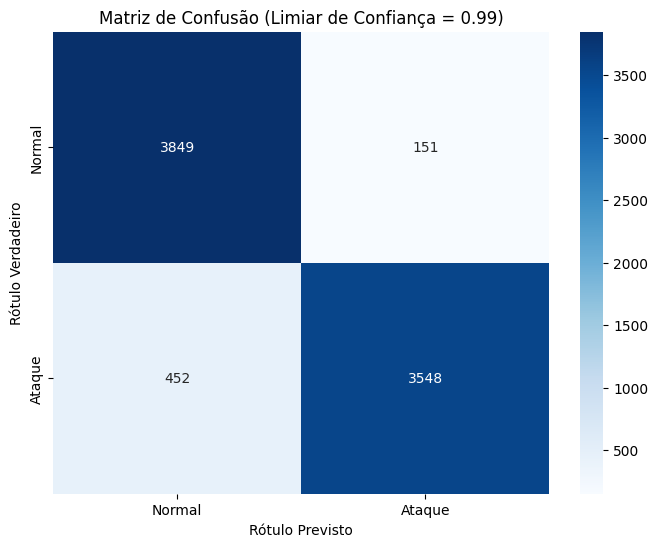

True Positives (TP): 3548
True Negatives (TN): 3849
False Positives (FP): 151
False Negatives (FN): 452

F1 Score: 0.9217
True Positive Rate (TPR) / Recall: 0.8870
True Negative Rate (TNR) / Specificity: 0.9623
--------------------
Threshold: 0.99
  Accuracy: 0.9246%
  Total Inference Time: 0.4725 s
  Early Exit Rate: 0.2303% (1842/8000)
--------------------


--- Model: BOTH_EA | Loader: CIC | TestID: 1 | Threshold: 0 ---
Model from: 'models/BOTH_EA_1.pth' carregado


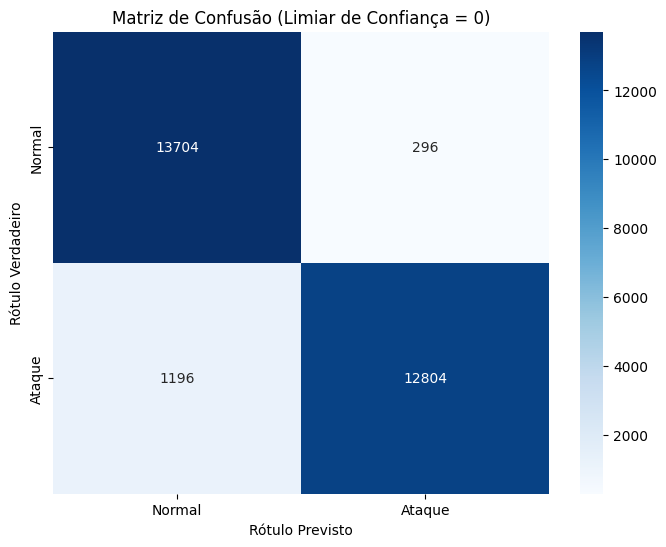

True Positives (TP): 12804
True Negatives (TN): 13704
False Positives (FP): 296
False Negatives (FN): 1196

F1 Score: 0.9449
True Positive Rate (TPR) / Recall: 0.9146
True Negative Rate (TNR) / Specificity: 0.9789
--------------------
Threshold: 0
  Accuracy: 0.9467%
  Total Inference Time: 1.0246 s
  Early Exit Rate: 1.0000% (28000/28000)
--------------------


--- Model: BOTH_EA | Loader: CIC | TestID: 2 | Threshold: 2 ---
Model from: 'models/BOTH_EA_2.pth' carregado


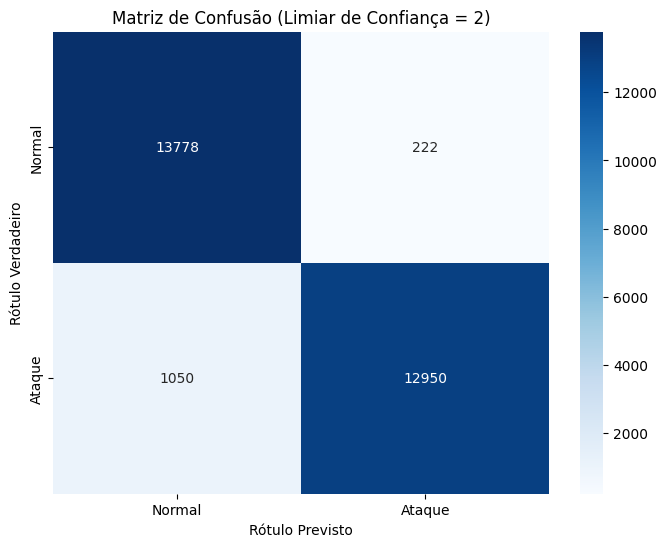

True Positives (TP): 12950
True Negatives (TN): 13778
False Positives (FP): 222
False Negatives (FN): 1050

F1 Score: 0.9532
True Positive Rate (TPR) / Recall: 0.9250
True Negative Rate (TNR) / Specificity: 0.9841
--------------------
Threshold: 2
  Accuracy: 0.9546%
  Total Inference Time: 1.4595 s
  Early Exit Rate: 0.0000% (0/28000)
--------------------


--- Model: BOTH_EA | Loader: CIC | TestID: 3 | Threshold: 0.99 ---
Model from: 'models/BOTH_EA_3.pth' carregado


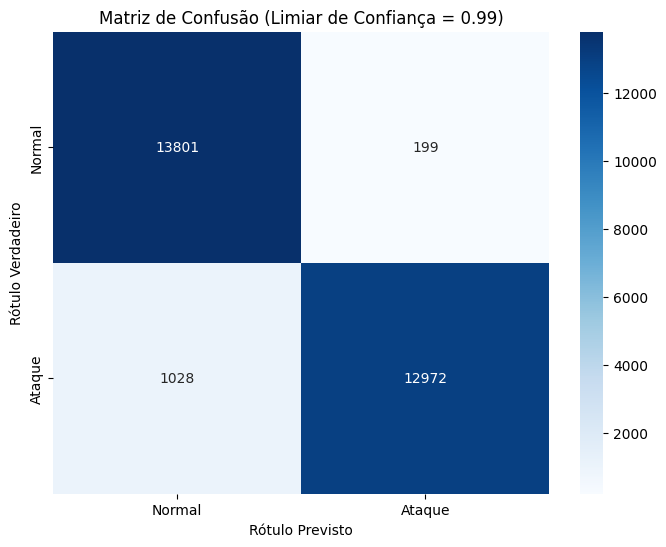

True Positives (TP): 12972
True Negatives (TN): 13801
False Positives (FP): 199
False Negatives (FN): 1028

F1 Score: 0.9548
True Positive Rate (TPR) / Recall: 0.9266
True Negative Rate (TNR) / Specificity: 0.9858
--------------------
Threshold: 0.99
  Accuracy: 0.9562%
  Total Inference Time: 1.6587 s
  Early Exit Rate: 0.1604% (4492/28000)
--------------------




In [23]:
for loader in range(len(test_loaders)):
    for test in test_ids:
        if test == 1:
            T = 0
        elif test == 2:
            T = 2
        elif test == 3:
            T = 0.99

        print(f"--- Model: {modelname} | Loader: {loader_names[loader]} | TestID: {test} | Threshold: {T} ---")

        model.load_state_dict(torch.load(f'models/{modelname}_{test}.pth'))
        print(f"Model from: 'models/{modelname}_{test}.pth' carregado")

        results = evaluate_model(model, test_loaders[loader], confidence_threshold=T, device=device)
        print("-" * 20)
        print(f"Threshold: {T}")
        print(f"  Accuracy: {results['accuracy']:.4f}%")
        print(f"  Total Inference Time: {results['total_inference_time_sec']:.4f} s")
        print(f"  Early Exit Rate: {results['exit_rate']:.4f}% ({results['exited_early_count']}/{results['total_samples']})")
        print("-" * 20)
        print("\n")